## Homework 01. Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [2]:
# In colab uncomment this cell
# ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/homeworks/homework01/utils.py -nc

In [4]:
try:
    data = pd.read_csv('../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

In [5]:
data.head(2)

,should_ban,comment_text
0,0,The picture on the article is not of the actor...
1,1,"Its madness. Shes of Chinese heritage, but JAP..."


In [6]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [7]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [8]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [9]:
# task: preprocess each comment in train and test

texts_train = np.array([preprocess(comment) for comment in texts_train]) #<YOUR CODE>
texts_test = np.array([preprocess(comment) for comment in texts_test]) #<YOUR CODE>

In [10]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [11]:
import itertools

In [16]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10_000, len(set(' '.join(texts_train).split())))

#<YOUR CODE>
total_vocabulary = dict()
for word in ' '.join(texts_train).split():
    total_vocabulary[word] = total_vocabulary.setdefault(word, 0) + 1
    
total_vocabulary = dict(sorted(total_vocabulary.items(), 
                               key = lambda item: item[1], reverse=True))

bow_vocabulary = list(dict(itertools.islice(total_vocabulary.items(), k)).keys())

print('example features:', sorted(bow_vocabulary)[::100])


example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


In [17]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    #<YOUR CODE>
    tokens = tokenizer.tokenize(text.lower())
    tokens_count = [tokens.count(token) for token in bow_vocabulary]
    return np.array(tokens_count, 'float32')


In [18]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [19]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [20]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

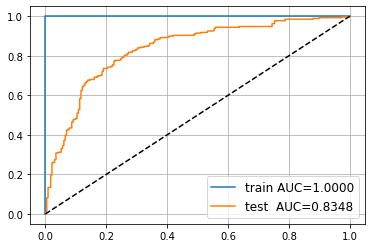

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [3]:
from utils import plot_train_process

In [22]:
model = nn.Sequential()

model.add_module('lin_1', nn.Linear(k_max, 2)) ### YOUR CODE HERE              
### YOUR CODE HERE

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [23]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [24]:
opt = torch.optim.Adadelta(model.parameters()) ### YOUR CODE HERE

In [25]:
X_train_bow_torch = torch.tensor(X_train_bow) ### YOUR CODE HERE
X_test_bow_torch = torch.tensor(X_test_bow) ### YOUR CODE HERE

y_train_torch = torch.tensor(y_train) ### YOUR CODE HERE
y_test_torch = torch.tensor(y_test) ### YOUR CODE HERE

Let's test that everything is fine

In [26]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [27]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

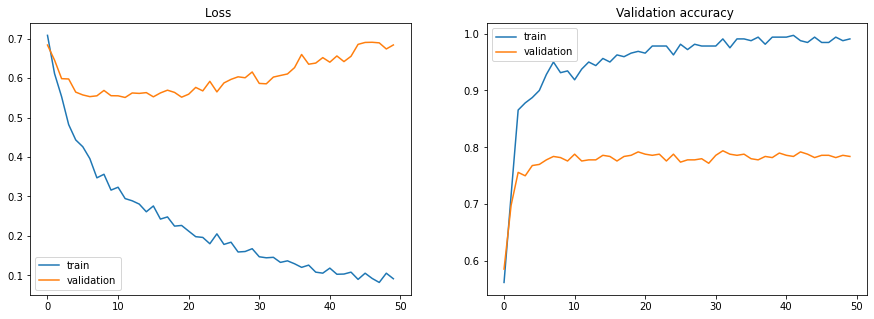

Sequential(
  (lin_1): Linear(in_features=5707, out_features=2, bias=True)
)

In [28]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            #print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
#             lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

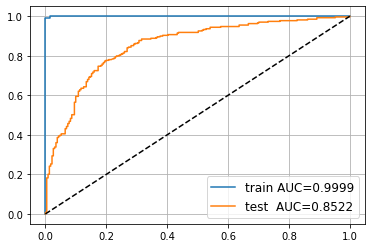

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [ ]:
# Your beautiful code here

In [70]:
def text_to_bow_k(text, bow_vocabulary_k):
   
    result = dict.fromkeys(bow_vocabulary_k, 0)
    
    for token in text.split():
        if token in result.keys():
            result[token] += 1
            
    result = np.array(list(result.values()), dtype = np.float32)        
    return result

k = 5510
accuracy = 0.776


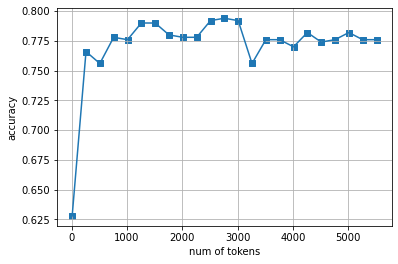

In [74]:
def model_with_k_tokens(k):
    
    bow_vocabulary_k = list(dict(itertools.islice(total_vocabulary.items(), k)).keys())
    
    X_train_bow_k_torch = torch.tensor(np.stack([text_to_bow_k(row, bow_vocabulary_k) for row in texts_train]), dtype=torch.float)
    X_test_bow_k_torch = torch.tensor(np.stack([text_to_bow_k(row, bow_vocabulary_k) for row in texts_test]), dtype=torch.float)
    
    model_k = nn.Sequential()
    model_k.add_module('lin_1',  nn.Linear(k, 2))
    opt = torch.optim.Adam(model_k.parameters())
    
    
    train_model(model_k, opt, lr_scheduler, X_train_bow_k_torch, 
                y_train_torch, X_test_bow_k_torch, y_test_torch, 
                show_plots = False)
    
    predictions_k = model_k(X_test_bow_k_torch)
    accuracy_k = accuracy_score(y_test_torch.cpu().numpy(), predictions_k.detach().numpy().argmax(axis=1))
    return accuracy_k



k_values = []
acc_values = []

for k in range(10, k_max, 250):
    k_values.append(k)
    temp_accuracy = model_with_k_tokens(k)
    acc_values.append(temp_accuracy)
    
    # ploting    
    display.clear_output(wait=True)
    print(f"k = {k}")
    print(f"accuracy = {temp_accuracy}")
    plt.scatter(k_values, acc_values, marker="s")
    plt.plot(k_values, acc_values)
    
    plt.xlabel("num of tokens")
    plt.ylabel("accuracy")
    plt.grid()
    plt.show()

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [75]:
# Your beautiful code here
class Tf_idf():
    
    def __init__(self):
        self.symbols = '!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n""1234''567890'
        #vocabulary of the words from all documents
        self.vocab = None
        
        #how many documents contain each word in the vicab
        self.counter = None
        
        # how many documents
        self.size = None
        
        # documents for train
        self.train_texts = None
        
        self.alpha = 0.0001
        
        # the dictinary for saving log of idf for words in vocab
        self.log_idf_values = None
        
    def fit(self, train_texts: list):
        """
        the train_texts should be a list of texts
        """
        self.train_texts = train_texts
        self.size = len(train_texts)
        all_documents = " ".join(train_texts)
        
        for symbol in self.symbols: 
            all_documents = all_documents.replace(symbol, " ").lower()
            
        self.vocab = list(set(all_documents.split(" ")))
        self.counter = {word : self.get_words_count(word) for word in self.vocab if len(word) > 1}
        # self.log_idf_values = {word : np.log10(self.size/(self.counter[word] + self.alpha)) for word in self.counter.keys()}
        self.log_idf_values = {word : np.log((self.size +1)/(self.counter[word] + 1)) + 1 for word in self.counter.keys()}
        # (math.log((1+N)/(count+1)))+1
    def get_words_count(self, word):
        """
        return how many documents contains the word 
        """
        count = 0
        for text in self.train_texts:
            count += int(word in text.lower().split())
        return count
    
    
    def get_tf_idf_values(self, texts):
        """
        return the tf_idf for texts
        """
        result = np.zeros(shape = (len(texts), len(self.vocab)))
        # print(texts)
        for i in range(len(texts)):
            # get the documnet
            current_text = texts[i]
        
            
            # delete special symbols
            for symbol in self.symbols:
                current_text = current_text.replace(symbol, " ").lower()
            
            # print(current_text)
            current_text = current_text.split()
            # print(current_text)
            # get the value for every word in the document
            for word in current_text:
                #print(word)
                if word in self.counter:
                    index = self.vocab.index(word)
                    tf = current_text.count(word)/len(current_text)
                    # print(word, tf, tf * self.log_idf_values[word])
                # print(word, tf)
        
                    result[i][index] = tf * self.log_idf_values[word]
            
            # print(result[i])
        
        return result
            
    
    def fit_transform(self, train_texts: list):
        """
        First the model is fited by train_text and then
        return the tf-idf matrixs
        """
        if self.train_texts is None:
            self.fit(train_texts)
        # print(self.vocab)    
        
        train_result = self.get_tf_idf_values(train_texts)
        return train_result
    
   
    def transform(self, text: list):
        """
        return the tf-idf matrixs for text
        """
        return self.get_tf_idf_values(text)

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [76]:
### YOUR CODE HERE

texts = data['comment_text'].values
target = data['should_ban'].values
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

texts_train = list(texts_train)
texts_test = list(texts_test)

tf_idf = Tf_idf()
tf_idf.fit(texts_train)

In [77]:
X_train_tfidf = tf_idf.transform(texts_train)
X_test_tfidf = tf_idf.transform(texts_test)

In [78]:
X_train_tfidf_torch = torch.tensor(X_train_tfidf,  dtype = torch.float)### YOUR CODE HERE
X_test_tfidf_torch = torch.tensor(X_test_tfidf,  dtype = torch.float) ### YOUR CODE HERE

y_train_torch = torch.tensor(y_train) ### YOUR CODE HERE
y_test_torch = torch.tensor(y_test) ### YOUR CODE HERE

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

In [88]:
model_2 = nn.Sequential()
model_2.add_module('l1',  nn.Linear(X_train_tfidf_torch.shape[1], 2))
opt = torch.optim.Adadelta(model_2.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

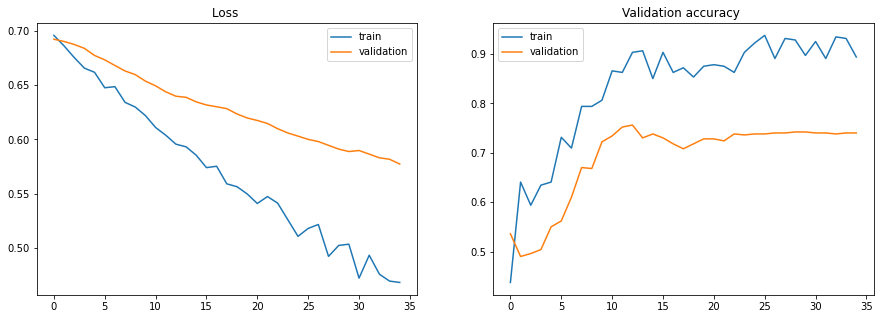

Sequential(
  (l1): Linear(in_features=5956, out_features=2, bias=True)
)

In [89]:
train_model(model_2, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=350)

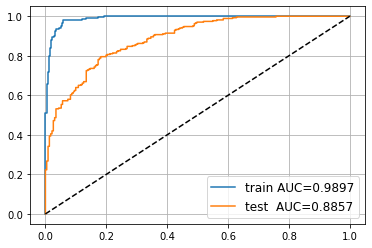

In [90]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train_torch, model_2),
    ('test ', X_test_tfidf_torch, y_test_torch, model_2)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [ ]:
# Your beautiful code here

In [91]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

#### Naive Bayes for BOW

In [92]:
naive_bayes_classifier_BOW = MultinomialNB()
naive_bayes_classifier_BOW.fit(X_train_bow, y_train)

MultinomialNB()

In [93]:
y_pred = naive_bayes_classifier_BOW.predict(X_test_bow)
print(metrics.classification_report(y_test, y_pred,
                                    target_names=['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.69      0.86      0.77       231
    Negative       0.85      0.67      0.75       269

    accuracy                           0.76       500
   macro avg       0.77      0.76      0.76       500
weighted avg       0.77      0.76      0.75       500



#### Naive Bayes for TF-iDF

In [94]:
naive_bayes_classifier_TF = MultinomialNB()
naive_bayes_classifier_TF.fit(X_train_tfidf, y_train)

MultinomialNB()

In [95]:
y_pred = naive_bayes_classifier_TF.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred,
                                    target_names=['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.70      0.91      0.79       231
    Negative       0.90      0.66      0.76       269

    accuracy                           0.78       500
   macro avg       0.80      0.79      0.77       500
weighted avg       0.81      0.78      0.77       500



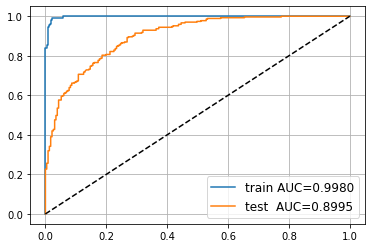

In [96]:
for name, X, y, model in [
    ('train', X_train_tfidf, y_train, naive_bayes_classifier_TF),
    ('test ', X_test_tfidf, y_test, naive_bayes_classifier_TF)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

_Your beautiful thoughts here_

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [ ]:
# Your beautiful code here

In [192]:
import gensim.downloader as api
pretr_model = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [193]:
def get_vector_for_phrase(phrase):
    phrase = phrase.split(" ")
    phrase.sort()
    vector = np.zeros(shape = (len(phrase), 300))
    for i in range(len(phrase)):
        word = phrase[i]
        if word in pretr_model.key_to_index:
            vector[i] = pretr_model.get_vector(word)
            
    return vector.mean(axis = 0)

In [194]:
def get_data_with_pretr(data):
    result = np.empty(shape = (len(data), 300))
    for i in range(len(texts_train)):
        vector_i = get_vector_for_phrase(data[i])
        result[i][:len(vector_i)] = get_vector_for_phrase(data[i])
    return result

In [195]:
train_data = torch.FloatTensor(get_data_with_pretr(texts_train))
test_data = torch.FloatTensor(get_data_with_pretr(texts_test))
train_data.shape, test_data.shape

(torch.Size([500, 300]), torch.Size([500, 300]))

In [233]:
model_3 = nn.Sequential()
model_3.add_module('l1', nn.Linear(300, 10))
model_3.add_module('relu1', nn.ReLU())
model_3.add_module('bn1', nn.BatchNorm1d(10))
model_3.add_module('drop1', nn.Dropout(p=0.5))
model_3.add_module('l3', nn.Linear(10, 2))

opt = torch.optim.Adam(model_3.parameters())
lr_scheduler = ReduceLROnPlateau(opt, patience=2)


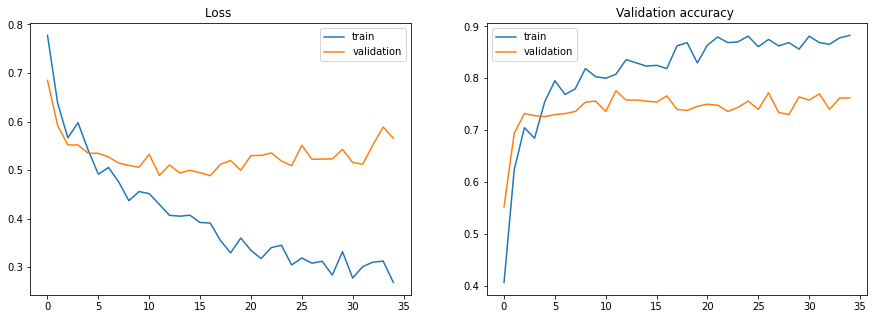

Sequential(
  (l1): Linear(in_features=300, out_features=10, bias=True)
  (relu1): ReLU()
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (l3): Linear(in_features=10, out_features=2, bias=True)
)

In [234]:
train_model(model_3, opt, lr_scheduler, train_data, y_train_torch, 
            test_data, y_test_torch, n_iterations=350, 
            batch_size=64)

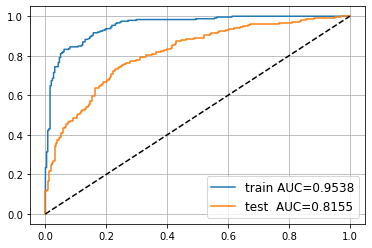

In [232]:
for name, X, y, model in [
    ('train', train_data, y_train, model_3),
    ('test ', test_data, y_test, model_3)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [ ]:
# logistic regression

In [235]:
log_reg_model  = LogisticRegression()
X_train = get_data_with_pretr(texts_train)
X_test = get_data_with_pretr(texts_test)

In [238]:
log_reg_model.fit(X_train, y_train)
y_pred = log_reg_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred,
                                    target_names=['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.74      0.79      0.76       231
    Negative       0.81      0.76      0.78       269

    accuracy                           0.77       500
   macro avg       0.77      0.77      0.77       500
weighted avg       0.77      0.77      0.77       500



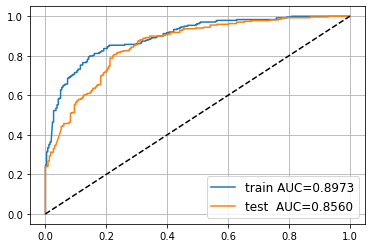

In [239]:
for name, X, y, model in [
    ('train', X_train, y_train, log_reg_model),
    ('test ', X_test, y_test, log_reg_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [243]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)

y_pred = naive_bayes_classifie.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

ValueError: Negative values in data passed to MultinomialNB (input X)